In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import LowRankRNN
from dsn.util.dsn_util import get_savedir
from dsn.util.plot_util import assess_constraints, plot_opt, dsn_pairplots, pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
from dsn.util.tf_DMFT_solvers import rank2_CDD_static_solve


In [2]:
EPS = 1e-16

# multivariate normal initialization variance
sigma_init = 2.0

dirstr = 'LowRankRNN'

# create an instance of the LowRankRNN system class
fixed_params = {'g':0.8, 'gammaLO':-0.14, 'gammaHI':0.08}

behavior_type = "CDD"
means = np.array([0.3])
variances = np.array([0.0001])
    
behavior = {'type':behavior_type, \
            'means':means, \
            'variances':variances}

# set model options
model_opts = {'rank':2, 'input_type':'input'}

solve_its = 200
solve_eps = 0.2

system = LowRankRNN(fixed_params, behavior, model_opts=model_opts, \
                    solve_its=solve_its, solve_eps=solve_eps)


# normalizing flow layer architecture
TIF_flow_type = 'PlanarFlowLayer'
# number of layers
nlayers = 10
mult_and_shift = 'post'
arch_dict = {'D':system.D, \
             'latent_dynamics':None, \
             'mult_and_shift':mult_and_shift, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers}

lr_order = -3

ind  0 behavior checked
ind  1 behavior checked


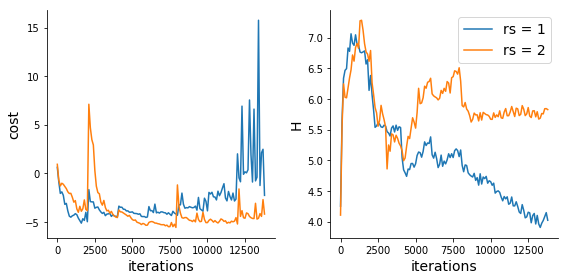

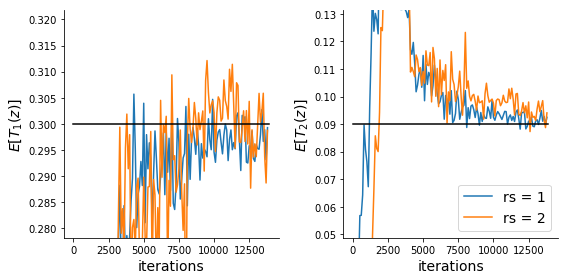

p values
0
1


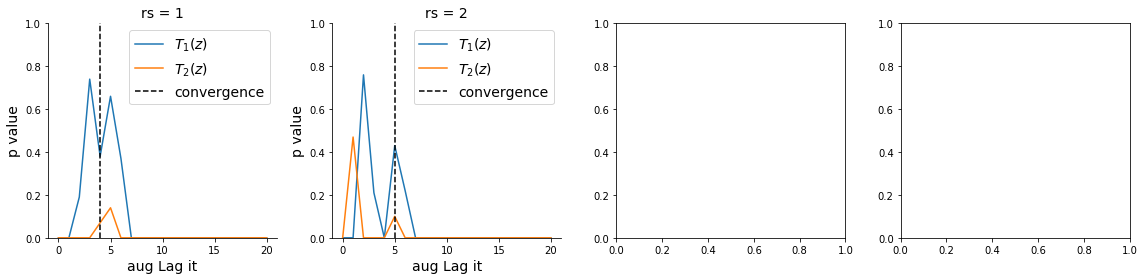

In [23]:
start_rs = 1
num_rs = 2

c_init_order = 2

random_seeds = np.arange(start_rs, num_rs+start_rs)


basedir = '/Users/sbittner/Documents/dsn/dsn/'
fnames = []
legendstrs = []
for i in range(num_rs):
    random_seed = random_seeds[i]
    dsndir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, c_init_order, random_seed, dirstr)
    fname = dsndir + 'opt_info.npz'
    fnames.append(fname)
    legendstrs.append('rs = %d' % random_seed)
    npzfile = np.load(fname)
    behavior_i = npzfile['behavior'][()]
    assert(approx_equal(behavior_i['means'], behavior['means'], EPS))
    assert(approx_equal(behavior_i['variances'], behavior['variances'], EPS))
    print('ind ', i, 'behavior checked')
    
figs, AL_final_its, p_values = plot_opt(fnames, legendstrs, con_method='1', frac_samps=0.2)

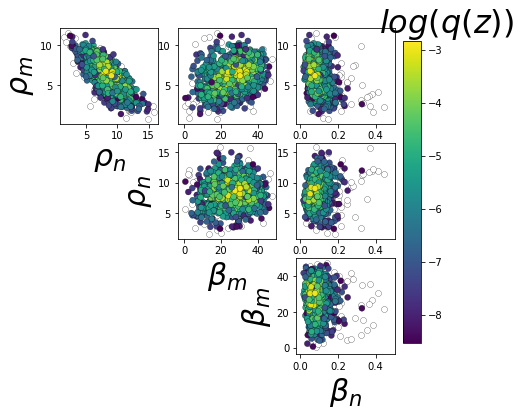

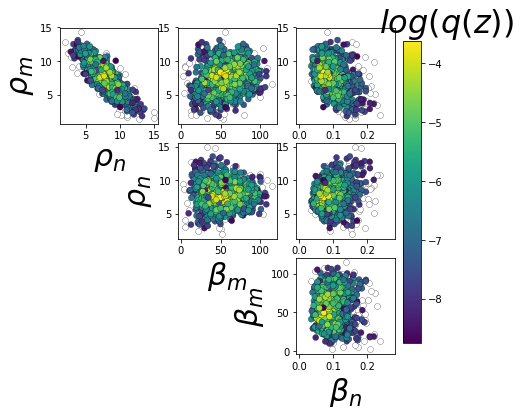

In [24]:
pfname = 'images/rank2_CDD_DSN_Z.png'
Zs = dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='log_q_z', legendstrs=[], AL_final_its=AL_final_its, \
              fontsize=30, ellipses=False, tri=True)

In [15]:
print(Zs[0].shape)
np.savez('temp_Z.npz', Z=Zs[0])

(1000, 4)


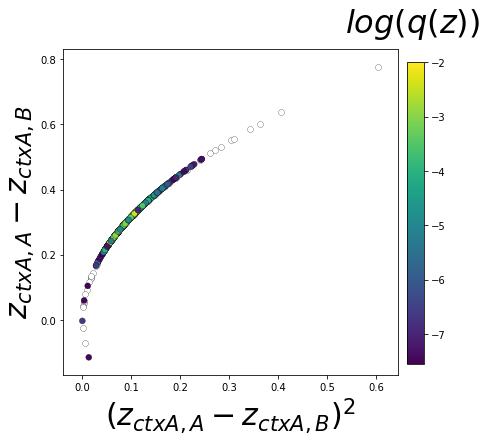

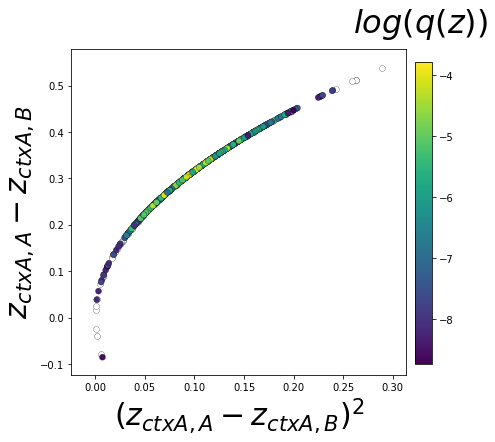

In [16]:
T_xs = dsn_pairplots(fnames, 'T_xs', system, 2, f_str='identity', \
                  c_str='log_q_z', legendstrs=[], AL_final_its=5*[6], \
                  fontsize=30, ellipses=False, tri=True)

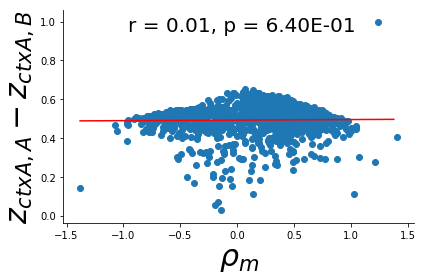

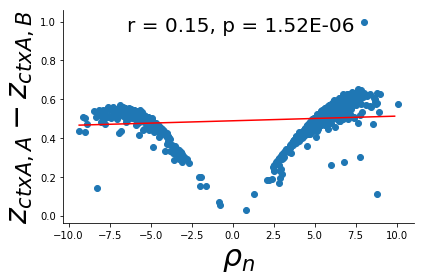

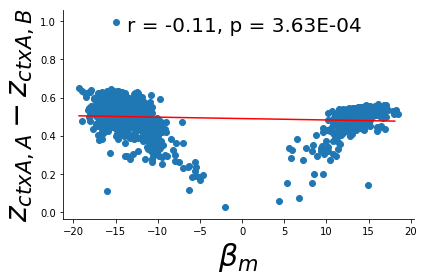

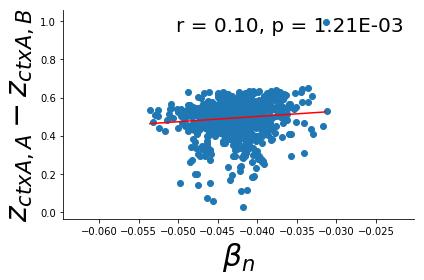

In [19]:
rs = 1
fontsize = 30
    
z_inds = [0,1,2,3]
T_inds = [0,0,0,0]
num_inds = len(z_inds)
for i in range(num_inds):
    z_ind = z_inds[i]
    T_ind = T_inds[i]
    lin_reg_plot(Zs[rs-1][:,z_ind], T_xs[rs-1][:,T_ind], system.z_labels[z_ind], system.T_x_labels[T_ind], \
                 pfname='images/corr%d' % (i+1), fontsize=fontsize)

In [11]:

def rank2_CDD_responses(Z, cA, cB):
    DTYPE = tf.float64
    num_conds = 4
    M = Z.shape[0]

    Z_tf = tf.placeholder(dtype=DTYPE, shape=Zs[0].shape)

    rhom = Z_tf[:,0]
    rhon = Z_tf[:,1]
    gammaLO = -Z_tf[:,2]
    gammaHI = Z_tf[:,3]

    gammaA = gammaHI
    gammaB = gammaLO

    cA = cA*tf.ones((M,), dtype=DTYPE) 
    cB = cB*tf.ones((M,), dtype=DTYPE)

    kappa1_init = -5.0 * tf.ones((M,), dtype=DTYPE)
    kappa2_init = -5.0 * tf.ones((M,), dtype=DTYPE)
    delta_0_init = 5.0 * tf.ones((M,), dtype=DTYPE)

    g = 0.2*tf.ones((M,), dtype=DTYPE)
    betam = 0.6*tf.ones((M,), dtype=DTYPE)
    betan = tf.ones((M,), dtype=DTYPE)

    solve_its = 100
    eps = 0.2

    kappa1, kappa2, delta_0, z, xs = rank2_CDD_static_solve(
                    kappa1_init,
                    kappa2_init,
                    delta_0_init,
                    cA,
                    cB,
                    g,
                    rhom,
                    rhon,
                    betam,
                    betan,
                    gammaA,
                    gammaB,
                    solve_its,
                    eps,
                    gauss_quad_pts=50,
                    db=True,
                )
    with tf.Session() as sess:
        _kappa1, _kappa2, _delta_0, _z, _xs = sess.run([kappa1, kappa2, delta_0, z, xs], {Z_tf:Zs[0]})
    
    return _z

M = Zs[0].shape[0]
cvals = [0.0, 0.25, 0.5, 0.75, 1.0]
num_cvals = len(cvals)
z_resps = np.zeros((M, num_cvals, num_cvals))

for i in range(num_cvals):
    cA = cvals[i]
    for j in range(num_cvals):
        cB = cvals[j]
        print(cA, cB)
        z_resps[:,i,j] = rank2_CDD_responses(Zs[0], cA, cB)

0.0 0.0
0.0 0.25
0.0 0.5
0.0 0.75
0.0 1.0
0.25 0.0
0.25 0.25
0.25 0.5
0.25 0.75
0.25 1.0
0.5 0.0
0.5 0.25
0.5 0.5
0.5 0.75
0.5 1.0
0.75 0.0
0.75 0.25
0.75 0.5
0.75 0.75
0.75 1.0
1.0 0.0
1.0 0.25
1.0 0.5
1.0 0.75
1.0 1.0


0 [-1.84789801 -0.62851068 -0.2768559   1.41594536]


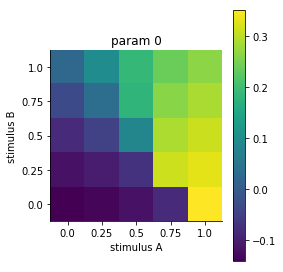

1 [ 1.89866825  0.53513665  0.34241187 -1.49732979]


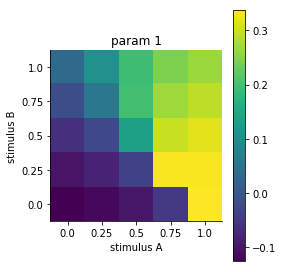

2 [-1.83948612 -0.62573226 -0.31023106  1.42348405]


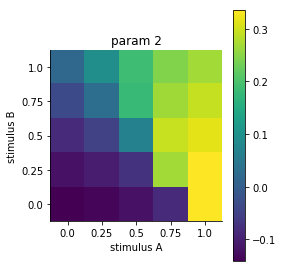

3 [ 2.15777059  0.5719172   0.20210679 -1.57045271]


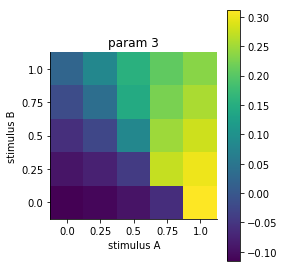

4 [-2.27851438 -0.43799023 -0.34571969  1.79754161]


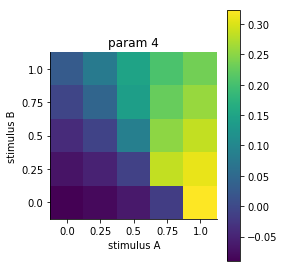

5 [-1.42495039 -0.7993757  -0.25351661  1.12077095]


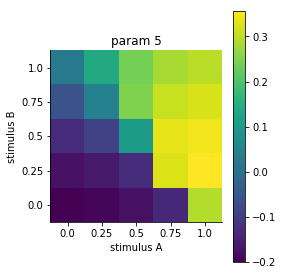

6 [ 1.78195587  0.66636964  0.24895141 -1.29126102]


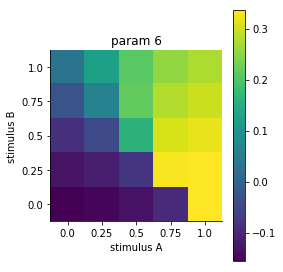

7 [-1.7560416  -0.66428016 -0.28020176  1.35593916]


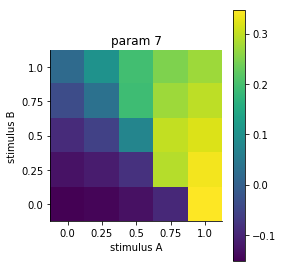

8 [ 1.55469757  0.76572906  0.24640455 -1.13508668]


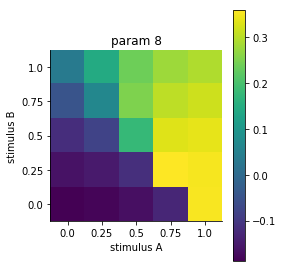

9 [ 1.83258604  0.61283843  0.27850519 -1.38022908]


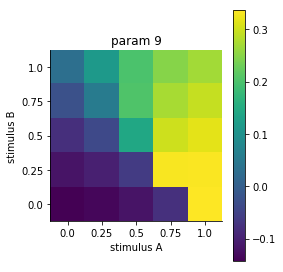

10 [-1.82055358 -0.57108585 -0.31911675  1.49480559]


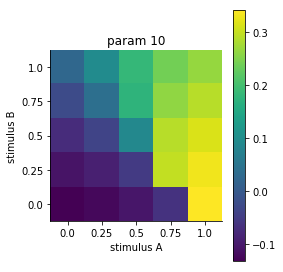

11 [ 0.65066863  0.28501844  0.21129667 -0.57877411]


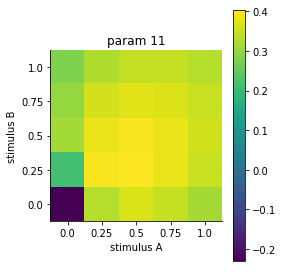

12 [ 3.04838866  0.23700961  0.20464822 -2.29225848]


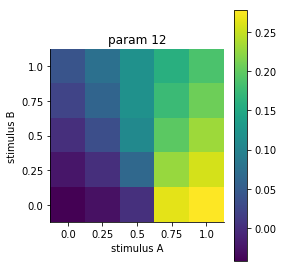

13 [-1.6332701  -0.53445195 -0.35004746  1.23828295]


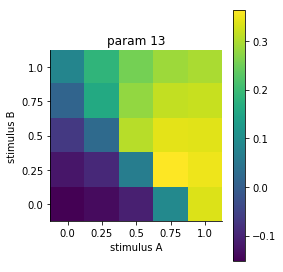

14 [ 1.6150126   0.65965555  0.32580059 -1.25321542]


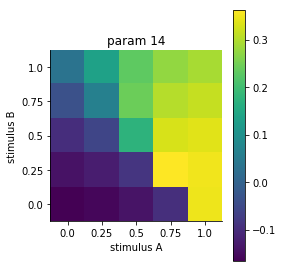

15 [-1.82056059 -0.6763492  -0.21349169  1.38211317]


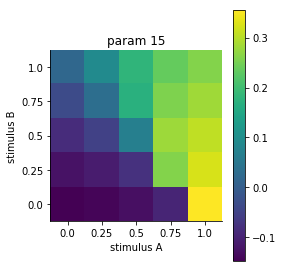

16 [ 2.29965152  0.49194432  0.26415031 -1.67946795]


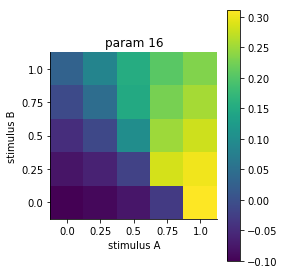

17 [ 1.674599    0.69531048  0.27791106 -1.22917972]


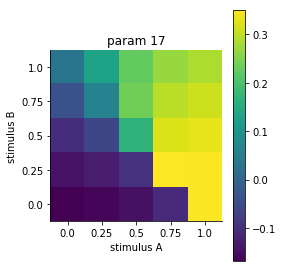

18 [-1.84935906 -0.63821858 -0.30925288  1.3998445 ]


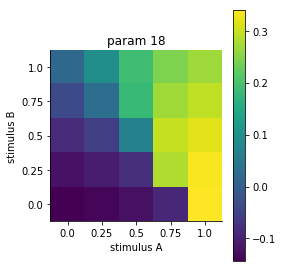

19 [-1.79682258 -0.66171029 -0.27963312  1.36708122]


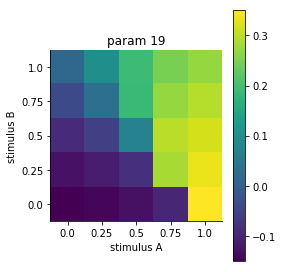

In [20]:
figsize = (4,4)
for i in range(20):
    print(i, Zs[0][i,:])
    plt.figure(figsize=figsize)
    plt.imshow(z_resps[i].T, aspect='equal', origin='lower')
    plt.xlabel('stimulus A')
    plt.ylabel('stimulus B')
    plt.title('param %d' %i)
    plt.colorbar()
    ax = plt.gca()
    ax.set_xticks(range(len(cvals)))
    ax.set_xticklabels(cvals)
    ax.set_yticks(range(len(cvals)))
    ax.set_yticklabels(cvals)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show()